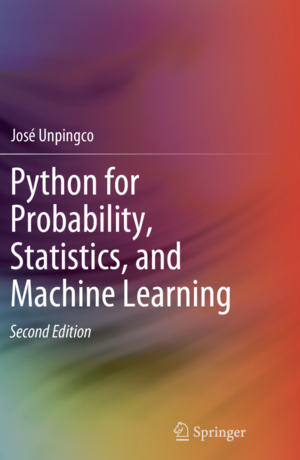

In [1]:
from IPython.display import Image
Image('../../Python_probability_statistics_machine_learning_2E.png',width=200)

<!-- add feature importances from RandomForestClassifier -->
<!-- TODO: [stochastic gradient trees and boosting](http://nbviewer.ipython.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb) -->
<!-- <https://en.wikipedia.org/wiki/Gradient_boosting> -->

<!-- Elements_of_Statistical_Learning_Hastie.pdf, Chap 10 -->

## Boosting Trees

To understand additive modeling using trees, recall the
Gram-Schmidt orthogonalization procedure for vectors.  The
purpose of this orthogonalization procedure is to create an
orthogonal set of vectors starting with a given vector
$\mathbf{u}_1$. We have already discussed the projection
operator in the section [ch:prob:sec:projection](#ch:prob:sec:projection).  The
Gram-Schmidt orthogonalization procedure starts with a
vector $\mathbf{v}_1$, which we define as the following:

$$
\mathbf{u}_1 = \mathbf{v}_1
$$

 with the corresponding projection operator $proj_{\mathbf{u}_1}$. The
next step in the procedure is to remove the residual of  $\mathbf{u}_1$
from $\mathbf{v}_2$, as in the following:

$$
\mathbf{u}_2 = \mathbf{v}_2 -  proj_{\mathbf{u}_1}(\mathbf{v}_2)
$$

 This procedure continues for $\mathbf{v}_3$ as in the following:

$$
\mathbf{u}_3 = \mathbf{v}_3 - proj_{\mathbf{u}_1}(\mathbf{v}_3) - proj_{\mathbf{u}_2}(\mathbf{v}_3)
$$

 and so on. The important aspect of this procedure is that new
incoming vectors (i.e., $\mathbf{v}_k$) are stripped of any pre-existing
components already present in the set of $\lbrace\mathbf{u}_1,\mathbf{u}_2,\ldots,\mathbf{u}_M \rbrace$.

Note that this procedure is sequential. That is, the *order*
of the incoming $\mathbf{v}_i$ matters [^rotation]. Thus,
any new vector can be expressed using the so-constructed
$\lbrace\mathbf{u}_1,\mathbf{u}_2,\ldots,\mathbf{u}_M
\rbrace$ basis set, as in the following:

[^rotation]: At least up to a rotation of the resulting
orthonormal basis.

$$
\mathbf{x} = \sum \alpha_i \mathbf{u}_i
$$

 The idea behind additive trees is to reproduce this procedure for
trees instead of vectors. There are many natural topological and algebraic
properties that we lack for the general problem, however. For example, we already
have well established methods for measuring distances between vectors for
the Gram-Schmidt procedure outlined above (namely, the $L_2$
distance), which we lack here.  Thus, we need the concept of *loss function*,
which is a way of measuring how well the process is working out at each
sequential step. This loss function is parameterized by the training data and
by the classification function under consideration: $ L_{\mathbf{y}}(f(x)) $.
For example, if we want a classifier ($f$) that selects the label $y_i$
based upon the input data $\mathbf{x}_i$ ($f :\mathbf{x}_i \rightarrow y_i)$,
then the squared error loss function would be the following:

$$
L_{\mathbf{y}}(f(x))  = \sum_i (y_i - f(x_i))^2
$$

 We represent the classifier in terms of a set of basis trees:

$$
f(x) = \sum_k \alpha_k u_{\mathbf{x}}(\theta_k)
$$

 The general algorithm for forward stagewise  additive modeling is 
the following:

   * Initialize $f(x)=0$

   * For $m=1$ to $m=M$, compute the following:

$$
(\beta_m,\gamma_m) = \argmin_{\beta,\gamma} \sum_i  L(y_i,f_{m-1}(x_i)+\beta b(x_i;\gamma))
$$

* Set $f_m(x) = f_{m-1}(x) +\beta_m b(x;\gamma_m) $

The key point is that the residuals from the prior step are used to fit the
basis function for the subsequent iteration.  That is, the following 
equation is being sequentially approximated.

$$
f_m(x) - f_{m-1}(x) =\beta_m b(x_i;\gamma_m)
$$

 Let's see how this works for decision trees and the exponential loss
function.

$$
L(x,f(x)) = \exp(-y f(x))
$$

 Recall that for the classification problem, $y\in \lbrace -1,1 \rbrace$. For 
AdaBoost, the basis functions are the individual classifiers, $G_m(x)\mapsto \lbrace -1,1 \rbrace$
The key step in the algorithm is the minimization step for
the objective function

$$
J(\beta,G) = \sum_i \exp(y_i(f_{m-1}(x_i)+\beta G(x_i)))
$$

$$
(\beta_m,G_m) = \argmin_{\beta,G} \sum_i \exp(y_i(f_{m-1}(x_i)+\beta G(x_i)))
$$

 Now, because of the exponential, we can factor out the following:

$$
w_i^{(m)} = \exp(y_i f_{m-1}(x_i))
$$

 as a weight on each data element and re-write the objective function as the following:

$$
J(\beta,G) = \sum_i w_i^{(m)} \exp(y_i \beta G(x_i))
$$

 The important observation here is that $y_i G(x_i)\mapsto 1$ if
the tree classifies $x_i$ correctly and $y_i G(x_i)\mapsto -1$ otherwise. 
Thus, the above sum has terms like the following:

$$
J(\beta,G) = \sum_{y_i\ne G(x_i)} w_i^{(m)} \exp(-\beta) + \sum_{y_i= G(x_i)} w_i^{(m)}\exp(\beta)
$$

 For $\beta>0$, this means that  the best $G(x)$ is
the one that incorrectly classifies for the largest weights. Thus, 
the minimizer is the following:

$$
G_m = \argmin_G \sum_i w_i^{(m)} I(y_i \ne G(x_i))
$$

 where $I$ is the indicator function (i.e.,
$I(\texttt{True})=1,I(\texttt{False})=0$). 

 For $\beta>0$, we can re-write the objective function
as the following:

$$
J= (\exp(\beta)-\exp(-\beta))\sum_i w_i^{(m)} I(y_i \ne G(x_i)) + \exp(-\beta) \sum_i w_i^{(m)}
$$

 and substitute $\theta=\exp(-\beta)$ so that

<!-- Equation labels as ordinary links -->
<div id="eq:bt001"></div>

$$
\begin{equation}
\frac{J}{\sum_i w_i^{(m)}} = \left(\frac{1}{\theta} - \theta\right)\epsilon_m+\theta
\label{eq:bt001} \tag{1}
\end{equation}
$$

 where

$$
\epsilon_m = \frac{\sum_i w_i^{(m)}I(y_i\ne G(x_i))}{\sum_i w_i^{(m)}}
$$

  is the error rate of the classifier with $0\le \epsilon_m\le 1$. Now,
finding $\beta$ is a straight-forward calculus minimization exercise on the
right side of Equation ([1](#eq:bt001)), which gives the following:

$$
\beta_m  = \frac{1}{2}\log \frac{1-\epsilon_m}{\epsilon_m}
$$

 Importantly, $\beta_m$ can become negative if
$\epsilon_m<\frac{1}{2}$, which would would violate our assumptions on $\beta$.
This is captured in the requirement that the base learner be better than just
random guessing, which would correspond to $\epsilon_m>\frac{1}{2}$.
Practically speaking, this means that boosting cannot fix a base learner that
is no better than a random guess. Formally speaking, this is known as the
*empirical weak learning assumption* [[schapire2012boosting]](#schapire2012boosting). 

Now we can move to the iterative weight update. Recall that

$$
w_i^{(m+1)} = \exp(y_i f_{m}(x_i)) = w_i^{(m)}\exp(y_i \beta_m G_m(x_i))
$$

 which we can rewrite as the following:

$$
w_i^{(m+1)} = w_i^{(m)}\exp(\beta_m)\exp(-2\beta_m I(G_m(x_i)=y_i))
$$

 This means that the data elements that are incorrectly classified have their
corresponding weights increased by $\exp(\beta_m)$ and those that are correctly
classified have their corresponding weights reduced by $\exp(-\beta_m)$.
The reason for the choice of the exponential loss function comes from the
following:

$$
f^{*}(x) = \argmin_{f(x)} \mathbb{E}_{Y\vert x}(\exp(-Y f(x))) = \frac{1}{2}\log \frac{\mathbb{P}(Y=1\vert x)}{\mathbb{P}(Y=\minus 1\vert x)}
$$

 This means that boosting is approximating a $f(x)$ that is actually
half the log-odds of the conditional class probabilities.  This can be
rearranged as the following

$$
\mathbb{P}(Y=1\vert x) = \frac{1}{1+\exp(\minus 2f^{*}(x))}
$$

 The important benefit of this general formulation for boosting, as a sequence
of additive approximations,  is that it opens the door to other choices of loss
function, especially loss functions that are based on robust statistics that
can account for errors in the training data (c.f. Hastie).

### Gradient Boosting

Given a differentiable loss function, the optimization process can be
formulated using numerical gradients. The fundamental idea is to treat the
$f(x_i)$ as a scalar parameter to be optimized over. Generally speaking,
we can think of the following loss function,

$$
L(f) = \sum_{i=1}^N L(y_i,f(x_i))
$$

 as a vectorized quantity

$$
\mathbf{f} = \lbrace f(x_1),f(x_2),\ldots, f(x_N) \rbrace
$$

 so that the optimization is over this vector

$$
\hat{\mathbf{f}} = \argmin_{\mathbf{f}} L(\mathbf{f})
$$

 With this general formulation we can use numerical optimization methods 
to solve for the optimal $\mathbf{f}$ as a sum of component vectors
as in the following:

$$
\mathbf{f}_M = \sum_{m=0}^M \mathbf{h}_m
$$

 Note that this leaves aside the prior assumption that $f$ 
is parameterized as a sum of individual decision trees.

$$
g_{i,m} = \left[ \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)} \right]_{f(x_i)=f_{m-1}(x_i)}
$$